In [18]:
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import xgboost as xgb
from DanceProj1.XGB_Genreclass import get_XGBclassifier
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data, data_to_features
import matplotlib.pyplot as plt

This notebook is for inspecting the model. get_XGBclassifier essentially does everything from Notebook 02. 

In [5]:
xgb_mod, X_test, y_test, y_pred, y_proba_pred, yprobdf = get_XGBclassifier()

In [6]:
X_test.index

Int64Index([1202, 1215, 1205, 1209, 1201, 1213, 1203, 1216, 1206, 1200, 1225,
            1222, 1232, 1221, 1233, 1226, 1234, 1223, 1220, 1252, 1247, 1240,
            1255, 1254, 1251, 1253, 1241, 1239, 1243, 1273, 1268, 1261, 1276,
            1275, 1272, 1274, 1262, 1260, 1264, 1294, 1289, 1282, 1297, 1296,
            1293, 1295, 1283, 1281, 1285, 1315, 1310, 1303, 1318, 1317, 1314,
            1316, 1304, 1302, 1306, 1336, 1331, 1324, 1339, 1338, 1335, 1337,
            1325, 1323, 1327, 1345, 1358, 1348, 1352, 1344, 1356, 1346, 1359,
            1349, 1343, 1365, 1375, 1369, 1364, 1368, 1372, 1366, 1363, 1382,
            1395, 1385, 1389, 1381, 1393, 1383, 1396, 1386, 1380],
           dtype='int64')

In [8]:
yprobdf.head()

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.170263,0.267068,0.012641,0.047949,0.053594,0.341692,0.016305,0.007686,0.045165,0.037638,1202,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.066016,0.069594,0.020239,0.185131,0.059306,0.431350,0.029318,0.030213,0.061076,0.047757,1215,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.139063,0.023080,0.013949,0.026192,0.016970,0.555234,0.005948,0.022866,0.043428,0.153269,1205,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
3,0.937929,0.004313,0.010657,0.006995,0.003250,0.023806,0.004207,0.000707,0.004798,0.003339,1209,Ballet Jazz,gJB_sFM_cAll_d07_mJB0_ch01
4,0.968065,0.001246,0.001063,0.000924,0.000889,0.019198,0.000757,0.002041,0.002581,0.003236,1201,Ballet Jazz,gJB_sFM_cAll_d09_mJB1_ch16


In [10]:
#split into dfs by genre
BJazzdf = yprobdf[yprobdf['True_Label']=='Ballet Jazz']
Breakdf = yprobdf[yprobdf['True_Label']=='Break']
Housedf = yprobdf[yprobdf['True_Label']=='House']
Krumpdf = yprobdf[yprobdf['True_Label']=='Krump']
LAhopdf = yprobdf[yprobdf['True_Label']=='LAhop']
Lockdf = yprobdf[yprobdf['True_Label']=='Lock']
Midhopdf = yprobdf[yprobdf['True_Label']=='Midhop']
Popdf = yprobdf[yprobdf['True_Label']=='Pop']
SJazzdf = yprobdf[yprobdf['True_Label']=='Street Jazz']
Waackdf = yprobdf[yprobdf['True_Label']=='Waack']

Genredfs = [BJazzdf, Breakdf, Housedf, Krumpdf, LAhopdf, Lockdf, Midhopdf, Popdf, SJazzdf, Waackdf]

([<matplotlib.axis.YTick at 0x7f9625018b80>,
 [Text(0, 0, 'Ballet Jazz'),
  Text(0, 1, 'Break'),
  Text(0, 2, 'House'),
  Text(0, 3, 'Krump'),
  Text(0, 4, 'LAhop'),
  Text(0, 5, 'Lock'),
  Text(0, 6, 'Midhop'),
  Text(0, 7, 'Pop'),
  Text(0, 8, 'Street Jazz'),
  Text(0, 9, 'Waack')])

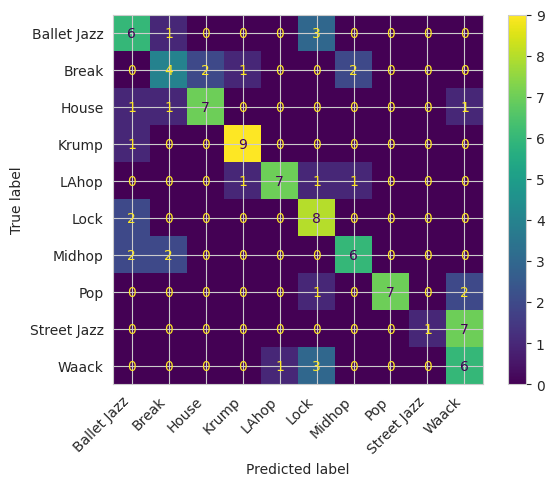

In [25]:
#inspect confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_mod, X_test, y_test)
#change xticks and yticks to labels

labels = yprobdf['True_Label'].unique()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels, rotation=45, ha='right')
plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels)

<Figure size 1000x1000 with 0 Axes>

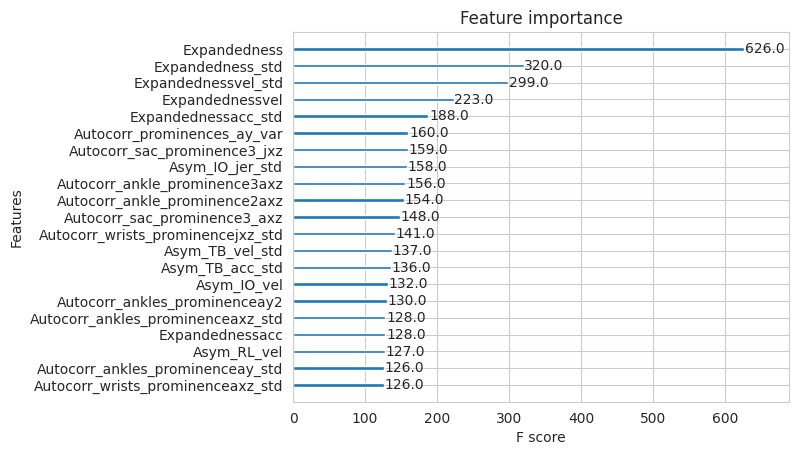

In [29]:
#check features importance of top 21 features
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
xgb.plot_importance(xgb_mod, max_num_features=21, importance_type='weight')
plt.show()


<Figure size 1000x1000 with 0 Axes>

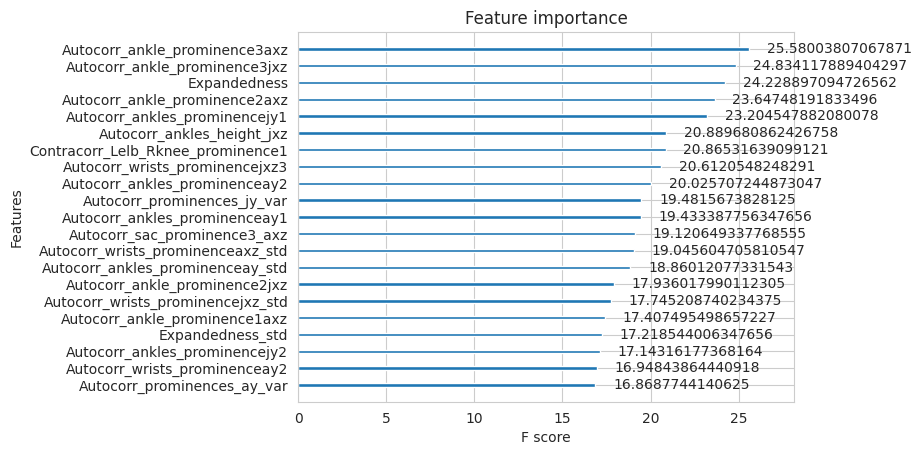

In [27]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
xgb.plot_importance(xgb_mod, max_num_features=21, importance_type='cover')
plt.show()


<Figure size 1000x1000 with 0 Axes>

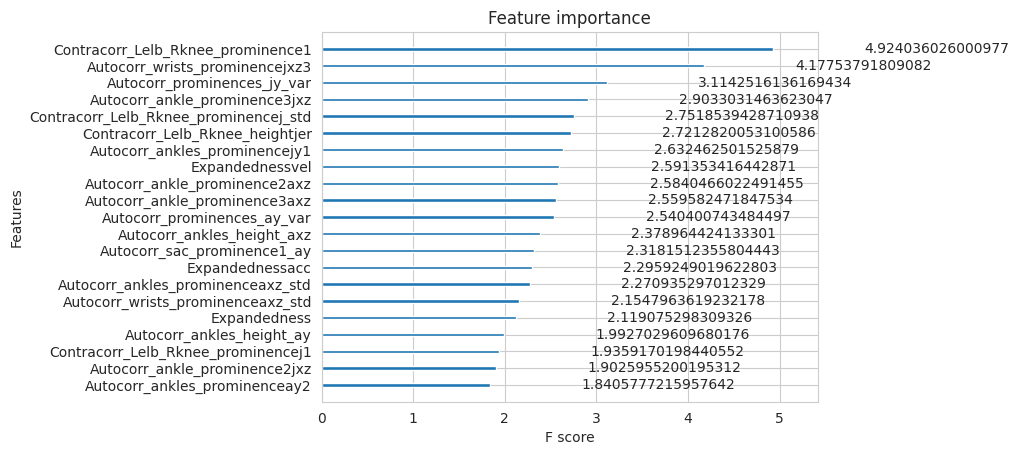

In [28]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
xgb.plot_importance(xgb_mod, max_num_features=21, importance_type='gain')
plt.show()


In [29]:
#get better understanding of the above spaces

In [11]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data
dfBasic, dfAdvanced = data_to_features(dataBM, dataFM)  #get features

#alphabetize dfs by genre (to avoid reordering by classifiers later)
dfAdvanced = dfAdvanced.sort_values(by='Genre')

#make new indexes for Advanced, starting after last index in Basic, for unique index per id
#this is so that Basic and Adv indexes dont overlap.
dfAdvanced.index = range(len(dfBasic.index), len(dfBasic.index)+len(dfAdvanced.index))

In [33]:
dfAdvanced.tail()

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1394,969.542085,98.855743,992.554874,329.221881,5066.963329,1481.952915,1186.902288,593.157740,1642.836948,9.656070,...,5.548718e+08,5.136387e+08,2.247123e+07,2.008864e+08,3.939626e+08,3.743875e+08,3.587747e+08,1.439571e+07,gWA_sFM_cAll_d25_mWA4_ch05,Waack
1395,928.198813,70.543630,919.877078,454.423360,4635.536604,2239.743494,5305.262381,1786.385563,508.076550,11.420752,...,4.259998e+08,3.933554e+08,6.320765e+07,4.347574e+07,6.279022e+08,5.793772e+08,4.710065e+08,6.558724e+07,gWA_sFM_cAll_d26_mWA3_ch14,Waack
1396,939.923978,68.239028,818.119115,372.186346,4164.762921,1884.353540,1088.842497,-11746.619719,10268.622584,5.731486,...,4.018333e+08,3.521439e+08,4.207317e+07,3.893858e+08,6.366089e+08,3.988821e+08,3.756609e+08,1.179205e+08,gWA_sFM_cAll_d27_mWA3_ch18,Waack
1397,996.041489,79.875845,1124.658078,501.066495,5702.299856,2560.830403,-1896.720798,547.698868,5561.120142,14.036626,...,8.163855e+08,7.443944e+08,6.045825e+07,1.755741e+08,8.769213e+08,7.280281e+08,5.528690e+08,1.324386e+08,gWA_sFM_cAll_d27_mWA5_ch20,Waack
1398,972.235847,83.451521,934.198651,332.413523,4702.131607,1563.975658,1113.834141,-270.571130,1136.730006,4.778593,...,5.548580e+08,5.339156e+08,1.878069e+07,1.540949e+08,5.286268e+08,5.230028e+08,4.677556e+08,2.746552e+07,gWA_sFM_cAll_d25_mWA2_ch03,Waack


In [27]:
ExpandednessADV = dfAdvanced[['Expandedness', 'Genre']]
#ExpandednessADV.head()
#use indeces from X_test to get the same rows as X_test
ExpandednessADV_test = ExpandednessADV.loc[X_test.index]
ExpandednessADV_test.head()

,Expandedness,Genre
1202,986.565303,Ballet Jazz
1215,952.230629,Ballet Jazz
1205,932.590413,Ballet Jazz
1209,993.748996,Ballet Jazz
1201,952.453800,Ballet Jazz


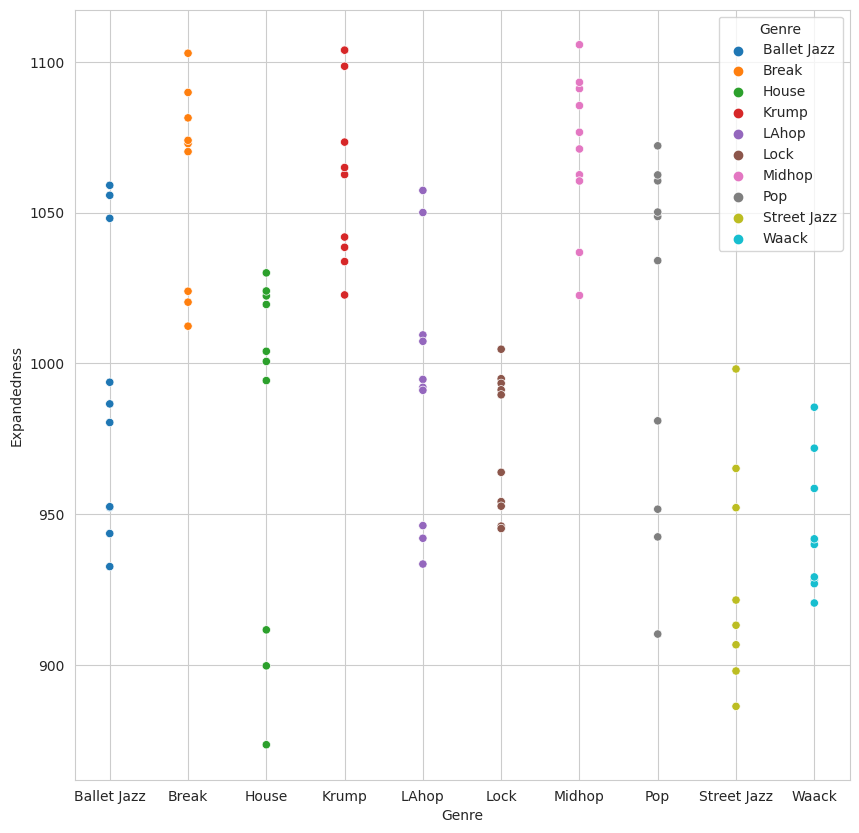

In [30]:
#scatter plot of Expandedness on y axis, dance genre on X axis
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
sns.scatterplot(data=ExpandednessADV_test, x='Genre', y='Expandedness', hue='Genre')
plt.show()


In [14]:
BJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in BJazzdf[BJazzdf['Ballet Jazz']>0.5].values:
        HitBJazz.append(Dance(data[0],dt=1/60))
        HitBJazz[-1].get_features()

(array([[[ 109.83432941,  201.87036406, -202.73906203],
         [ 109.88517448,  201.93933031, -202.13561189],
         [ 109.94835058,  201.56331125, -201.11458054],
         ...,
         [  34.51861687,  179.46824823, -174.6640695 ],
         [  32.81741157,  179.6785649 , -174.66399875],
         [  31.76427969,  180.09850239, -174.54608117]],
 
        [[ 112.17984004,  203.31211703, -199.27409321],
         [ 112.0871457 ,  203.59090792, -198.67092876],
         [ 112.09462745,  203.33938713, -197.675246  ],
         ...,
         [  36.76318318,  183.00077928, -176.09731901],
         [  35.37427805,  183.0411426 , -175.96246351],
         [  34.46164139,  183.44411212, -175.58073341]],
 
        [[ 119.86772236,  201.95154648, -209.49262425],
         [ 119.9853227 ,  201.88101487, -208.85024434],
         [ 119.72684895,  201.89343861, -208.2346333 ],
         ...,
         [  25.39028084,  186.81374303, -171.49854114],
         [  23.91048192,  187.20510567, -171.34432091],


In [ ]:
#inspect the misclassified Ballet Jazz pieces
yprob_misBJazz = BJazzdf[BJazzdf['Ballet Jazz']<0.5]
yprob_misBJazz

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.102943,0.155679,0.018298,0.104901,0.062415,0.314966,0.030880,0.015018,0.108549,0.086350,1565,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.033570,0.023562,0.024930,0.086090,0.024906,0.672489,0.022066,0.014703,0.074809,0.022876,1591,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.052050,0.021557,0.007512,0.013277,0.032721,0.623952,0.007026,0.012608,0.022553,0.206744,1571,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
6,0.079782,0.294858,0.144204,0.030350,0.121908,0.044607,0.041026,0.014055,0.115876,0.113333,1567,Ballet Jazz,gJB_sFM_cAll_d08_mJB0_ch08


In [ ]:
#Create Dance object for Ballet Jazz pieces that were correctly, and incorrectly classified
HitBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in BJazzdf[BJazzdf['Ballet Jazz']>0.5].values:
        HitBJazz.append(Dance(data[0],dt=1/60))
        HitBJazz[-1].get_features()

print(len(HitBJazz)) 

#get Dance object for all Ballet Jazz pieces that were misclassified
missBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in yprob_misBJazz.id.values:
        print(data[-1])
        missBJazz.append(Dance(data[0], dt=1/60))
        missBJazz[-1].get_features()

print(len(missBJazz))
print(missBJazz[0])
print(missBJazz[0].acceleration.shape)

6
gJB_sFM_cAll_d07_mJB4_ch05
gJB_sFM_cAll_d08_mJB0_ch08
gJB_sFM_cAll_d09_mJB3_ch18
gJB_sFM_cAll_d09_mJB2_ch17
4
(15, 1919, 3)


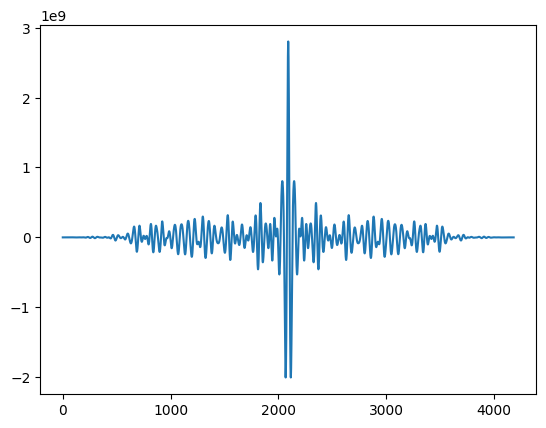

In [17]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first misclassified Ballet Jazz piece
anklecorry_jer = (np.correlate(missBJazz[0].jerk[13][:,1], missBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(missBJazz[0].jerk[14][:,1], missBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

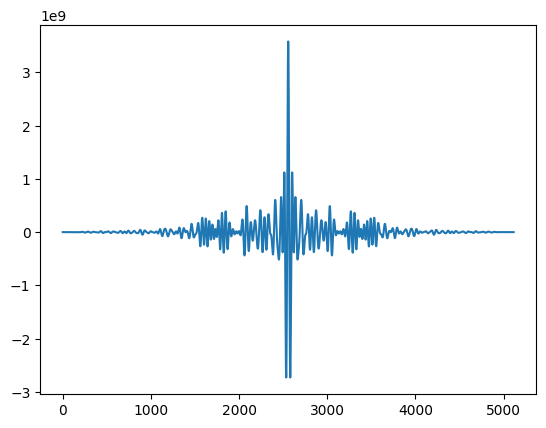

In [20]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first correctly classified Ballet Jazz piece
anklecorry_jer = (np.correlate(HitBJazz[0].jerk[13][:,1], HitBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(HitBJazz[0].jerk[14][:,1], HitBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

In [25]:
#look at the features of the misclassified Ballet Jazz pieces
testset.loc[testset.id.isin(yprob_misBJazz.id)]

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1609,952.230629,103.339482,1173.811693,590.516327,5529.458983,2822.475105,-3101.460326,-3842.680385,-18763.210259,13.561335,...,7.749144e+08,6.417610e+08,3.189269e+08,1.187765e+08,9.508543e+08,7.796116e+08,6.957601e+08,1.061593e+08,gJB_sFM_cAll_d09_mJB2_ch17,Ballet Jazz
1583,986.565303,106.354552,1250.544711,716.203115,6256.392835,3838.150549,979.998271,-8376.755982,7664.762826,5.987970,...,1.379766e+09,9.206970e+08,3.159570e+08,6.021521e+08,1.457539e+09,1.285451e+09,1.222143e+09,9.946194e+07,gJB_sFM_cAll_d07_mJB4_ch05,Ballet Jazz
1579,1016.357632,99.647915,1285.371478,587.623914,5784.954412,2807.437497,2195.687077,1578.601247,1954.705135,6.754464,...,9.035397e+08,7.964862e+08,8.472218e+07,1.002533e+09,1.734618e+09,1.686987e+09,1.495129e+09,1.035124e+08,gJB_sFM_cAll_d08_mJB3_ch11,Ballet Jazz
1587,1048.961981,107.692128,1234.471461,737.767102,5619.424194,3698.488138,9465.520424,-1080.890634,1052.127688,34.725294,...,1.543689e+09,1.448671e+09,5.126360e+07,4.751784e+08,1.018493e+09,8.528029e+08,7.857072e+08,9.783448e+07,gJB_sFM_cAll_d08_mJB1_ch09,Ballet Jazz
